# Classification using websites embeddings

This notebook merge the textual and visual embeddings of websites and used them to train class-wise binary classifiers.

### Loading and pre-processing the data

In [83]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

import ast
import math

from tqdm import tqdm

from sklearn.metrics import precision_recall_fscore_support

import matplotlib.pyplot as plt

from matplotlib import rcParams

In [84]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [86]:
# this dataframe contains the textual embeddings
df_t = pd.read_csv('/dlabdata1/lugeon/dmozfinalset/dmoz_lang_text_embeddings.gz', index_col=0)
df_t.head(5)

,uid,url,cat0,error,embed_url,embed_domain,embed_metatags,embed_text,embed_title,embed_description,embed_keywords,embed_links
0,2424165,www.speech-and-phone.de,Computers,uimctdkl:oooooooo,"[0.060655515640974045, 0.21340367197990417, -4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","[0.05247274413704872, 0.08826844394207001, 0.1...","[0.17049936950206757, 0.3826030492782593, -0.0...","[0.16197238862514496, 0.31466931104660034, -0....","[-0.008254689164459705, 0.11043740808963776, 0...","[0.031460825353860855, 0.10673479735851288, 0...."
1,290861,www.abakus.de,Computers,uimctdkl:oooooo_o,"[-0.03831346333026886, 0.11123624444007874, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.07217922061681747, 0.1010865569114685, 0.17...","[0.25987574458122253, 0.35377758741378784, 0.2...","[-0.04988153278827667, 0.5871794819831848, -0....",NaN,"[0.07821475714445114, 0.03716801851987839, 0.2..."
2,623605,www.add-in-world.com,Computers,uimctdkl:oooooooo,"[-0.14618022739887238, 0.10078339278697968, 0....","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.07250160723924637, 0.052183691412210464, 0....","[0.0074517009779810905, 0.306285560131073, -0....","[0.1350153684616089, 0.25630608201026917, -0.1...","[-0.02077578194439411, 0.22364230453968048, 0....","[0.10269737243652344, -0.010017908178269863, 0..."
3,906236,www.euronet.de,Computers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1662217,www.homepage4u.net,Computers,uimctdkl:ooooo___,"[0.19163523614406586, -0.12171020358800888, 0....","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.09341035783290863, 0.06160615384578705, 0.1...","[0.019808843731880188, 0.10328571498394012, 0....",NaN,NaN,NaN


Some urls could not be accessed and therefore are qualified as _erroneus_. In such a case, their _error_ field is set to _NaN_. Even if the url can be accessed, some features may not be computable and are set to _NaN_.

In [91]:
print('There is {}% of erroneus urls'.format(df_t.error.isna().sum() / df_t.shape[0]))

There is 0.1716819973718791% of erroneus urls


In [4]:
# we discard erroneus urls
df_t = df_t[df_t.error.notna()]

In [5]:
df_t.shape

(113463, 12)

We export the cleaned urls so that we can collect screenshots and forward them to the CVM to obtain visual embeddings

In [6]:
df_t[['uid', 'url', 'cat0']].to_csv('/dlabdata1/lugeon/dmozfinalset/dmoz_lang_clean_urls.gz', compression='gzip')

... collecting screenshots ... computing visual embeddings ...

In [584]:
# this dataframe contains the visual embeddings
df_v = pd.read_csv('/dlabdata1/lugeon/dmozfinalset/dmoz_lang_visual_embeddings.gz', index_col=0)
df_v.head(5)

,uid,embed_graph
0,1000021,"[0.8024751543998718, 0.5643119215965271, 0.498..."
1,1000107,"[0.8033103942871094, 0.46896466612815857, 0.39..."
2,100016,"[0.44025373458862305, 0.320512980222702, 0.623..."
3,1000247,"[1.6630299091339111, 0.2737491726875305, 0.331..."
4,1000260,"[0.5779597163200378, 0.024376489222049713, 0.0..."


In [8]:
# we merge the textual and visual
df = df_t.merge(df_v, on='uid', how='inner')

In [9]:
# thos dataframe contains the languages of the samples
df_lang = pd.read_csv('/dlabdata1/lugeon/dmozfinalset/dmoz_lang.gz', index_col=0)
df_lang.head(1)

,uid,url,cat0,lang
934747,2094851,www.gyrosystem.co.uk,Computers,English


In [10]:
# we merge with the languages
df = df.merge(df_lang[['uid', 'lang']], how='inner', on='uid')

In [11]:
# final number of samples
df.shape

(102096, 14)

In [12]:
df.head(1)

,uid,url,cat0,error,embed_url,embed_domain,embed_metatags,embed_text,embed_title,embed_description,embed_keywords,embed_links,embed_graph,lang
0,2424165,www.speech-and-phone.de,Computers,uimctdkl:oooooooo,"[0.060655515640974045, 0.21340367197990417, -4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","[0.05247274413704872, 0.08826844394207001, 0.1...","[0.17049936950206757, 0.3826030492782593, -0.0...","[0.16197238862514496, 0.31466931104660034, -0....","[-0.008254689164459705, 0.11043740808963776, 0...","[0.031460825353860855, 0.10673479735851288, 0....","[1.0454500913619995, 0.22354736924171448, 0.11...",Deutsch


In [13]:
# samples per category
cat_count = df.groupby('cat0').uid.count()
cat_count

cat0
Arts          18891
Business      27321
Computers      4062
Games          3739
Health         4151
Home           2312
News           1140
Recreation     7903
Reference      3246
Science        3303
Shopping       7784
Society       12282
Sports         5962
Name: uid, dtype: int64

In [15]:
# different kinds of embeddings we have 
embeddings = [s for s in df.columns.values if s.startswith('embed')]
embeddings

['embed_url',
 'embed_domain',
 'embed_metatags',
 'embed_text',
 'embed_title',
 'embed_description',
 'embed_keywords',
 'embed_links',
 'embed_graph']

In the next step, we need to convert every string array of the dataframe to numpy and replace the _NaN_ features by the mean of others present xlm-r-embedded-features.

In [16]:
def convert_string_array(s):
    if type(s) == str:
        return np.fromstring(s[1:-1], sep=',') # need to remove the bracket for the method to work
    else:
        return s

In [19]:
for e in embeddings:
    df[e] = df[e].apply(convert_string_array)

In [20]:
xlmr_embeddings = ['embed_url', 'embed_text', 'embed_title', 'embed_description', 'embed_keywords', 'embed_links']

In [21]:
def xlmr_mean(row):
    mean = np.zeros(768)
    counter = 0
    for e in xlmr_embeddings:
        if type(row[e]) == np.ndarray:
            counter += 1
            mean += row[e]
    return mean / counter

In [22]:
df['xlmr_mean'] = df.apply(xlmr_mean, axis=1)

In [23]:
def remove_nan(val):
    if type(val) == np.ndarray:
        return val
    else:
        return np.zeros(768)
    

In [24]:
def replace_nan(column):
    is_nan = column.apply(lambda row: int(type(row) != np.ndarray))
    nan_removes = column.apply(remove_nan) 
    return df.xlmr_mean * is_nan + nan_removes * (1 - is_nan)

In [25]:
df[xlmr_embeddings] = df[xlmr_embeddings].apply(replace_nan)

In [26]:
# check that we don't have NaN anymore
df.isna().sum()

uid                  0
url                  0
cat0                 0
error                0
embed_url            0
embed_domain         0
embed_metatags       0
embed_text           0
embed_title          0
embed_description    0
embed_keywords       0
embed_links          0
embed_graph          0
lang                 0
xlmr_mean            0
dtype: int64

In [27]:
# this summaries which features are missing
df.error.value_counts()

uimctdkl:ooooo__o    28392
uimctdkl:oooooo_o    28245
uimctdkl:oooooooo    25115
uimctdkl:ooooo___     7932
uimctdkl:ooooooo_     4562
uimctdkl:oooooo__     1972
uimctdkl:ooooo_oo     1682
uimctdkl:ooo_____     1565
uimctdkl:oooo____      931
uimctdkl:oooo___o      499
uimctdkl:ooooo_o_      465
uimctdkl:ooo_o___      413
uimctdkl:ooo_oo__      167
uimctdkl:oooo_ooo       44
uimctdkl:oooo_o_o       25
uimctdkl:oooo_oo_       22
uimctdkl:oooo__oo       11
uimctdkl:ooo____o       11
uimctdkl:ooo__oo_       10
uimctdkl:ooo__o__        7
uimctdkl:ooo_ooo_        7
uimctdkl:ooo___o_        4
uimctdkl:ooo_o_o_        3
uimctdkl:ooo_o__o        3
uimctdkl:oooo_o__        3
uimctdkl:oooo__o_        2
uimctdkl:ooo__ooo        2
uimctdkl:ooo_oooo        1
uimctdkl:_oooo__o        1
Name: error, dtype: int64

In [77]:
def missing_feature(error, feature):
    return error[error.find(feature) + 9] == '_'  

In [82]:
# percentage of missing features
df.error.apply(lambda e: missing_feature(e, 'l')).sum() / df.shape[0]

0.17694131013947656

In [28]:
def is_valid(error):
    #return error[12] == 'o' # we want websites with text content
    return True

In [55]:
df_valid = df[df.error.apply(is_valid)] 

df_valid.reset_index(drop=True, inplace=True)

In [30]:
print("There is {:.2f}% of valid embeddings".format(df_valid.shape[0] / df.shape[0]))

There is 1.00% of valid embeddings


### Classification models

This is a standard binary classifier, defined by the dimension of the input, the number of layers and the dimension of hidden layers.



In [156]:
class BinaryClassifier(nn.Module):
    def __init__(self, features_dim, internal_dim, n_layers):
        super(BinaryClassifier, self).__init__()
        
        if n_layers == 1:
            layers = [torch.nn.Linear(features_dim, 1).to(device)]
            
        else:
            first_layer = torch.nn.Linear(features_dim, internal_dim).to(device)
            last_layer = torch.nn.Linear(internal_dim, 1).to(device)
            medium_layers = (n_layers-2) * [torch.nn.Linear(internal_dim, internal_dim).to(device)]
            layers = [first_layer] + medium_layers + [last_layer]
            
        self.layers = nn.ModuleList(layers)
        
        self.drop = torch.nn.Dropout(0.5) # dropout of 0.5 before each layer

    def forward(self, x):
        
        x = self.drop(x)
        
        for l in self.layers[:-1]:
            x = l(x)
            x = F.relu(self.drop(x))
            
        x = self.layers[-1](x)
        
        return x

This class implements dynamic meta-embeddings. It is defined be the size of the latent dimension and the dimensions of the different embeddings at the input.

In [32]:


class DME(nn.Module):
    
    def __init__(self, latent_dim, embeddings_dim):
        """
        the dimensions of the prior embeddings must be passed has a list
        """
        super(DME, self).__init__()
        
        self.n_embeddings = len(embeddings_dim) # number of prior embeddings
        self.transforms = nn.ModuleList([torch.nn.Linear(dim, latent_dim).to(device) for dim in embeddings_dim]) # linear transformation into the latent space
        self.attention = torch.nn.Linear(latent_dim, 1) # linear transformation defining the attention
        self.softmax = nn.Softmax(dim=1) # to normalize the attention 
        
    def forward(self, embeddings):
        """
        The embeddings are given as tuples of the form [samples x embedding_dim]
        """
        
        # first we transform each prior embedding into the latent space
        latent_embeddings = [transform(x) for transform, x in zip(self.transforms, embeddings)] # this is a list
        
        # then we apply the attention transformation to each of the latent embeddings
        att = torch.cat([self.attention(x) for x in latent_embeddings], dim=1) # this is a tensor
        
        # we normalize the attention and reshape for multiplication
        att_coeffs = self.softmax(att).reshape(-1, 1, self.n_embeddings)
        
        # we reshape for multiplication
        latent_embeddings_t = torch.cat(latent_embeddings, dim=1).reshape(-1, self.n_embeddings, latent_dim)
        
        # the reshape is so that we multiply matrices of the form 
        # [#samples x 1 x #embeddings] @ [#samples x #embeddings x latent_dim]
        
        aggregation = att_coeffs.matmul(latent_embeddings_t)
        
        
        return aggregation.squeeze()

This class combine dynamic meta-embeddings with a binary classifier.

In [33]:
class DynamicClassifier(nn.Module):
    
    def __init__(self, embeddings_dim, latent_dim, internal_dim, n_layers):
        super(DynamicClassifier, self).__init__()
        
        self.dme = DME(latent_dim, embeddings_dim)
        self.classifier = BinaryClassifier(latent_dim, internal_dim, n_layers)
        self.embeddings_dim = embeddings_dim
        
    def forward(self, x):
        
        splitted_embeddings = x.split(self.embeddings_dim, dim=1)
        latent_embedding = self.dme(splitted_embeddings)
        output = self.classifier(latent_embedding)
        
        return output


### Training procedure

In [34]:
df_valid.head(1)

,uid,url,cat0,error,embed_url,embed_domain,embed_metatags,embed_text,embed_title,embed_description,embed_keywords,embed_links,embed_graph,lang,xlmr_mean
0,2424165,www.speech-and-phone.de,Computers,uimctdkl:oooooooo,"[0.060655515640974045, 0.21340367197990417, -4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","[0.05247274413704872, 0.08826844394207001, 0.1...","[0.17049936950206757, 0.3826030492782593, -0.0...","[0.16197238862514496, 0.31466931104660034, -0....","[-0.008254689164459705, 0.11043740808963776, 0...","[0.031460825353860855, 0.10673479735851288, 0....","[1.0454500913619995, 0.22354736924171448, 0.11...",Deutsch,"[0.07813435901577274, 0.20268611361583075, 0.0..."


We select the features to use for the classification 

In [523]:
#features = ['embed_url', 'embed_domain', 'embed_metatags', 'embed_text', 'embed_title', 'embed_description', 'embed_keywords', 'embed_links']
features = embeddings
#features = ['embed_url', 'embed_domain']

In [524]:
# we convert the dataframe columns into a matrix
embeddings_sequence = [np.concatenate(df_valid[e].to_numpy()).reshape(df_valid.shape[0], -1) for e in features]
embeddings_concatenated = np.concatenate((embeddings_sequence), axis=1)
embeddings_concatenated.shape

(102096, 5157)

In [469]:
# splits for dme
[x.shape[0] for x in df_valid[features].iloc[0][features]]

[768, 17, 20, 768, 768, 768, 768, 768, 512]

In [152]:
def hinge_loss(output, target):
    return torch.mean(torch.clamp(1 - output * target, min=0))

In [153]:
splits = [x.shape[0] for x in df_valid[features].iloc[0][features]]
latent_dim = 300

nb_epochs = 100
batch_size = 128


def train_procedure(n_layers, internal_dim, hingeloss, dme,
                    train_inputs, train_targets, test_inputs, test_targets, test_langs,
                    verbose):
    """
    Train the specified model on the given inputs and targets,
    returns the accuracy, precison, recall and languages of correctly predicted samples
    """
    
    if dme:
        model = DynamicClassifier(splits, latent_dim, internal_dim, n_layers)
    else:
        model = BinaryClassifier(train_inputs[0].shape[0], internal_dim, n_layers).to(device)
    

    nb_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    #print("Number of parameters: {}".format(nb_trainable_params))

    if hingeloss:
        criterion = hinge_loss
        train_targets = 2 * train_targets - 1 
        test_targets = 2 * test_targets - 1
    else:
        criterion = nn.BCEWithLogitsLoss()

    optimizer = optim.Adam(model.parameters(), 1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10, verbose=verbose)
    

    for e in range(nb_epochs):

        model.train()

        for input, target in zip(train_inputs.split(batch_size), train_targets.split(batch_size)):

            output = model(input).view(-1)
            
            loss = criterion(output, target)
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        with torch.no_grad():

            model.eval()

            # computing test accuracy
            test_outputs = model(test_inputs).view(-1)

            if hingeloss:
                test_preds = 2 * (test_outputs > 0).int() - 1 
            else:
                test_preds = torch.round(torch.sigmoid(test_outputs))

            test_corrects = test_preds == test_targets
            test_acc = torch.sum(test_corrects).item() / test_targets.shape[0]

            if verbose:

                train_outputs = model(train_inputs).view(-1)

                train_loss = criterion(train_outputs, train_targets)
                test_loss = criterion(test_outputs, test_targets)

                if hingeloss:
                    train_preds = 2 * (train_outputs > 0).int() - 1 

                else:
                    train_preds = torch.round(torch.sigmoid(train_outputs))

                train_corrects = train_preds == train_targets

                train_acc = torch.sum(train_corrects).item() / train_targets.shape[0]


                print("Epoch {}".format(e))
                print("Train loss : {:.3f}".format(train_loss) +\
                      " | Test loss : {:.3f}".format(test_loss) +\
                      " | Train acc : {:.3f}".format(train_acc) +\
                      " | Test acc : {:.3f}".format(test_acc))


                scheduler.step(test_acc)
        
    # computes test metrics at the end of training
    with torch.no_grad():

            model.eval()

            test_outputs = model(test_inputs).view(-1)

            if hingeloss:
                test_preds = 2 * (test_outputs > 0).int() - 1 

            else:
                test_preds = torch.round(torch.sigmoid(test_outputs))
        
            # precision and recall
            metrics = precision_recall_fscore_support(test_targets.cpu().detach(), 
                                                      test_preds.cpu().detach(),
                                                      average='binary')

            # languages 
            test_langs_corrects = test_langs[test_corrects.cpu()].tolist()
    
    del model
        
    return test_acc, metrics[0], metrics[1], test_langs_corrects

            

### Japanese samples

We'll also need japanese samples for computing the zero-shot performances. We load and pre-process japanese embeddings in the next cells

In [102]:
df_jap_t = pd.read_csv('/dlabdata1/lugeon/dmozfinalset/dmoz_jap_text_embeddings.gz', index_col=0)

In [103]:
df_jap_t.head(5)

,uid,url,cat0,error,embed_url,embed_domain,embed_metatags,embed_text,embed_title,embed_description,embed_keywords,embed_links
0,2082749,check-it.org,Games,uimctdkl:ooooo__o,"[0.13966946303844452, -0.0007298514246940613, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.06329157948493958, 0.031256053596735, 0.134...","[0.2610689401626587, 0.22599197924137115, 0.11...",NaN,NaN,"[0.11875490099191666, -0.06502202153205872, 0...."
1,683810,exacapture.web.fc2.com,Games,uimctdkl:ooooo__o,"[0.10781887918710709, -0.09011103957891464, 0....","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.009637555107474327, -0.02530670538544655, 0...","[-0.011406837031245232, 0.078156016767025, 0.0...",NaN,NaN,"[0.11652213335037231, 0.0039430647157132626, 0..."
2,1379134,karuborn.net,Games,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1588381,www.dc-station.com,Games,uimctdkl:oooooo_o,"[0.10283076763153076, 0.05008787661790848, 0.2...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.07922540605068207, -0.010591729544103146, 0...","[0.25859445333480835, -0.03985521197319031, 0....","[-0.01235119253396988, 0.13617123663425446, 0....",NaN,"[0.13486681878566742, -0.03432171419262886, 0...."
4,2078566,adbiyo.web.fc2.com,Games,uimctdkl:ooooo__o,"[0.10187240689992905, 0.14092285931110382, 0.1...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.002973441733047366, 0.07457809150218964, 0...","[0.010755900293588638, 0.05997844785451889, 0....",NaN,NaN,"[0.08551055938005447, 0.12402795255184174, 0.1..."


In [104]:
print('There is {}% of erroneus urls'.format(df_jap_t.error.isna().sum() / df_jap_t.shape[0]))

There is 0.12913461538461538% of erroneus urls


In [105]:
df_jap_t = df_jap_t[df_jap_t.error.notna()]

In [106]:
df_jap_t[['uid', 'url', 'cat0']].to_csv('/dlabdata1/lugeon/dmozfinalset/dmoz_jap_clean_urls.gz', compression='gzip')

In [107]:
df_jap_v = pd.read_csv('/dlabdata1/lugeon/dmozfinalset/dmoz_jap_visual_embeddings.gz', index_col=0)

In [108]:
df_jap = df_jap_t.merge(df_jap_v, on='uid', how='inner')

In [109]:
cat_count = df_jap.groupby('cat0').uid.count()
cat_count

cat0
Arts          594
Business      569
Computers     593
Games         501
Health        578
Home          537
News          474
Recreation    517
Reference     516
Science       598
Shopping      554
Society       563
Sports        516
Name: uid, dtype: int64

In [110]:
for e in embeddings:
    df_jap[e] = df_jap[e].apply(convert_string_array)
    
df_jap['xlmr_mean'] = df_jap.apply(xlmr_mean, axis=1)

df_jap[xlmr_embeddings] = df_jap[xlmr_embeddings].apply(replace_nan)

In [356]:
embeddings_sequence_jap = [np.concatenate(df_jap[e].to_numpy()).reshape(df_jap.shape[0], -1) for e in features]
embeddings_concatenated_jap = np.concatenate((embeddings_sequence_jap), axis=1)
embeddings_concatenated_jap.shape

(7110, 3877)

### Classification results

In [292]:
categories = np.sort(df_valid.cat0.unique()).tolist()

def compute_performances(n_layers, internal_dim, hingeloss, dme, japanese=False):
    """
    Train the defined model in a 5-fold cross-validation fashion for each class,
    return the test performances of each folds,
    test either on last fold or on japanese samples
    """
    
    n_fold = 5

    accuracies = np.zeros((len(categories), n_fold))
    precisions = np.zeros((len(categories), n_fold))
    recalls = np.zeros((len(categories), n_fold))
    total_langs_corrects = []

    first_cat = True

    c = 0
    for ref_cat in categories:

        print(ref_cat)

        nb_positive = (df_valid.cat0 == ref_cat).sum()
        

        # we select the same number of positive and negative samples 
        positive_idx = df_valid[df_valid.cat0 == ref_cat].index.values.tolist()
        negative_idx = df_valid[df_valid.cat0 != ref_cat].sample(nb_positive, random_state=42).index.values.tolist()

        df_cat = df_valid.iloc[positive_idx + negative_idx]
        df_cat = df_cat.sample(frac=1, random_state=42) # shuffling the data

        inputs = embeddings_concatenated[df_cat.index.values]
        targets = df_cat.cat0.apply(lambda cat: int(cat == ref_cat)).values
        langs = df_cat.lang.values

        # transforming in torch tensors
        inputs = torch.FloatTensor(inputs).to(device)
        targets = torch.FloatTensor(targets).to(device)

        samples_per_fold = math.ceil(df_cat.shape[0] / n_fold)

        idx = np.arange(df_cat.shape[0]).tolist()

        acc = []
        prec = []
        rec = []
        langs_correct = []

        for i in range(n_fold):

            verbose = i == 0 and first_cat
            #verbose = False

            test_idx = idx[i*samples_per_fold: (i+1)*samples_per_fold]
            train_idx = idx[:i*samples_per_fold] + idx[(i+1)*samples_per_fold:]
            
            if japanese:
                
                df_jap_cat = df_jap[df_jap.cat0 == ref_cat]
                df_jap_ncat = df_jap[df_jap.cat0 != ref_cat]
                pos_jap = df_jap_cat.index.values.tolist()
                neg_jap = df_jap_ncat.sample(df_jap_cat.shape[0], random_state=42).index.values.tolist()
                
                test_inputs = embeddings_concatenated_jap[pos_jap + neg_jap]
                test_targets = df_jap.cat0.apply(lambda cat: int(cat == ref_cat)).values[pos_jap + neg_jap]
                
                test_inputs = torch.FloatTensor(test_inputs).to(device)
                test_targets = torch.FloatTensor(test_targets).to(device)
                
                test_langs = np.array((2 * len(pos_jap))*['Japanese'])
                
            else:
                test_inputs = inputs[test_idx]
                test_targets = targets[test_idx]
                test_langs = langs[test_idx]

            train_inputs = inputs[train_idx]
            train_targets = targets[train_idx]

            a, p, r, l = train_procedure(n_layers, internal_dim, hingeloss, dme,
                                         train_inputs, train_targets, test_inputs, test_targets, test_langs, 
                                         verbose=verbose)

            langs_correct += l

            accuracies[c, i] = a
            precisions[c, i] = p
            recalls[c, i] = r
            
        total_langs_corrects += [langs_correct]

        first_cat = False
        
        del inputs
        del targets
        
        c += 1
        
    return accuracies, precisions, recalls, total_langs_corrects

We can also do a grid-search to find the model with the best performances

In [45]:
n_layers_grid = [1, 2, 3]
internal_dim_grid = [300]
hingeloss_grid = [False]
dme_grid = [True, False]

grid_search = np.zeros((len(dme_grid), len(hingeloss_grid), len(n_layers_grid), len(internal_dim_grid)))

d = 0
for dme in dme_grid:
    
    hl = 0
    for hingeloss in hingeloss_grid:

        nl = 0
        for n_layers in n_layers_grid:

            idim = 0
            for internal_dim in internal_dim_grid:

                print('hinge: {}, layers: {}, internal dim: {}, dme: {}'.format(hingeloss, n_layers, internal_dim, dme))

                results = compute_performances(n_layers, internal_dim, hingeloss, dme)
                accuracies, accuracies_err, precisions, precisions_err, recalls, recalls_err, total_langs_corrects = results
                grid_search[d, hl, nl, idim] = np.mean(accuracies)

                idim += 1
            nl += 1
        hl += 1
    d += 1
        

hinge: False, layers: 1, internal dim: 300, dme: True
Arts
Business
Computers
Games
Health
Home
News
Recreation
Reference
Science
Shopping
Society
Sports
hinge: False, layers: 2, internal dim: 300, dme: True
Arts
Business
Computers
Games


KeyboardInterrupt: 

or go directly with a desired model

In [525]:
results = compute_performances(1, 300, hingeloss=False, dme=False, japanese=False)

Arts
Epoch 0
Train loss : 0.488 | Test loss : 0.492 | Train acc : 0.801 | Test acc : 0.799
Epoch 1
Train loss : 0.437 | Test loss : 0.444 | Train acc : 0.815 | Test acc : 0.810
Epoch 2
Train loss : 0.415 | Test loss : 0.423 | Train acc : 0.821 | Test acc : 0.816
Epoch 3
Train loss : 0.402 | Test loss : 0.411 | Train acc : 0.826 | Test acc : 0.821
Epoch 4
Train loss : 0.393 | Test loss : 0.403 | Train acc : 0.830 | Test acc : 0.824
Epoch 5
Train loss : 0.387 | Test loss : 0.398 | Train acc : 0.832 | Test acc : 0.826
Epoch 6
Train loss : 0.382 | Test loss : 0.394 | Train acc : 0.835 | Test acc : 0.826
Epoch 7
Train loss : 0.378 | Test loss : 0.390 | Train acc : 0.837 | Test acc : 0.827
Epoch 8
Train loss : 0.375 | Test loss : 0.387 | Train acc : 0.838 | Test acc : 0.828
Epoch 9
Train loss : 0.372 | Test loss : 0.385 | Train acc : 0.840 | Test acc : 0.829
Epoch 10
Train loss : 0.369 | Test loss : 0.383 | Train acc : 0.841 | Test acc : 0.830
Epoch 11
Train loss : 0.367 | Test loss : 0.382 

In [526]:
# results
accuracies, precisions, recalls, total_langs_corrects = results

From the languages of the correctly predicted samples, we compute and plot the distribution w.r.t to the languages

In [527]:
def get_lang_fraction(langs):
    count = pd.Series(langs).value_counts().loc[['English', 'Deutsch', 'Français', 'Italiano']].values
    return count / count.sum()

In [576]:
def get_lang_err(langs):
    errs = np.zeros((13, 4))
    for i in range(len(langs)):
        splitted = np.array_split(total_langs_corrects[i], 5)
        counts = [pd.Series(a).value_counts() for a in splitted]
        fracs = [s / s.sum() for s in counts]
        values = [s.loc[['English', 'Deutsch', 'Français', 'Italiano']].values for s in fracs]
        err = np.concatenate(values).reshape((5, -1)).std(axis=0) * 2 / np.sqrt(5)
        errs[i, :] = err
    return errs

In [577]:
lang_fraction = np.concatenate([get_lang_fraction(lang_correct) for lang_correct in total_langs_corrects]).reshape(13, 4)

In [578]:
lang_errors = get_lang_err(total_langs_corrects)

<ipython-input-583-40889fa1771f>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=13)


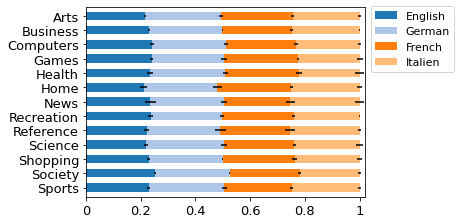

In [583]:
languages = ['English', 'German', 'French', 'Italien']
labels = categories
y = np.arange(len(labels))
width = 0.6

cmap = plt.cm.get_cmap('tab20')

fig, ax = plt.subplots(figsize=(5, 3.5))

for i in range(len(languages)):
    if i == 0:
        ax.barh(y, lang_fraction[:, i], width, xerr=lang_errors[:, i], label=languages[i], color=cmap(i))
    else:
        ax.barh(y, lang_fraction[:, i], width, xerr=lang_errors[:, i], label=languages[i], left=lang_fraction[:, :i].sum(axis=1), color=cmap(i))

ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=13)

ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=13)
 

ax.set_xlim([0,1.02])
ax.set_ylim([-1 + 0.35, len(categories) - 0.35])

ax.invert_yaxis()
        
ax.legend(fontsize=11, loc='upper right', bbox_to_anchor=(1.34, 1.03))
        
plt.show()

Then we plot the accuracy, precision and recal for each category

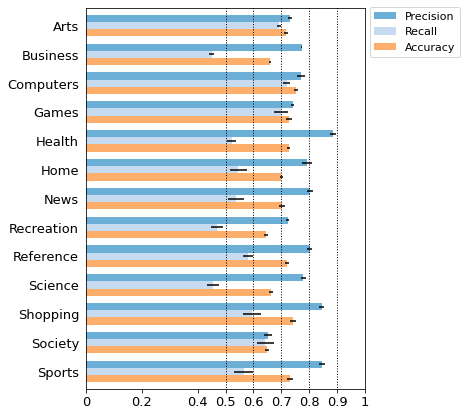

In [336]:
labels = categories

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
capsize = 0

cmap = plt.cm.get_cmap('tab20c')

color1 = cmap(1)
color2 = cmap(3)
color3 = cmap(6)

precisions_mean = precisions.mean(axis=1)
precisions_err = precisions.std(axis=1) * 2 / np.sqrt(5)

recalls_mean = recalls.mean(axis=1)
recalls_err = recalls.std(axis=1) * 2 / np.sqrt(5)

accuracies_mean = accuracies.mean(axis=1)
accuracies_err = accuracies.std(axis=1) * 2 / np.sqrt(5)

fig, ax = plt.subplots(figsize=(5, 7))
rects1 = ax.barh(x - width, 
                precisions_mean, 
                width, 
                label='Precision', 
                xerr=precisions_err, 
                capsize=capsize, 
                color=color1)

rects2 = ax.barh(x , 
                recalls_mean, 
                width, 
                label='Recall', 
                xerr=recalls_err, 
                capsize=capsize, 
                color=color2)

rects3 = ax.barh(x + width, 
                accuracies_mean, 
                width, 
                label='Accuracy', 
                xerr=accuracies_err, 
                capsize=capsize, 
                color=color3)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


#autolabel(rects1)
#autolabel(rects2)


ax.set_yticks(x)
ax.set_yticklabels(labels, fontsize=13)

ax.set_xticks([0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.set_xticklabels([0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], fontsize=13)

ax.invert_yaxis() 

ax.set_xlim([0,1])
ax.set_ylim([-1 + 0.4, len(categories) - 0.4])

ax.set_ylim(ax.get_ylim()[::-1])

ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    labelleft=True) # labels along the bottom edge are off

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    top=False,      # ticks along the bottom edge are off
    labeltop=False,
    bottom=True,
    labelbottom=True) # labels along the bottom edge are off


ax.legend(fontsize=11, loc='upper right', bbox_to_anchor=(1.36, 1.018))


ax.vlines([0.5, 0.6, 0.7, 0.8, 0.9], ymin=-1, ymax=13, linestyles='dotted', colors='black', linewidths=1)

#fig.tight_layout()

#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Verdana']

plt.savefig('prec_rec_acc.png', bbox_inches='tight')
plt.show()

In [472]:
np.mean(accuracies), np.mean(recalls), np.mean(precisions)

(0.8309058750790863, 0.8182006108565661, 0.8397586284161996)

Finally we run the classifiers with different sets of features and plot the performances for each set

In [473]:
visual_accuracies = accuracies.mean(axis=0)
visual_recalls = recalls.mean(axis=0)
visual_precisions = precisions.mean(axis=0)

In [466]:
text_accuracies = accuracies.mean(axis=0)
text_recalls = recalls.mean(axis=0)
text_precisions = precisions.mean(axis=0)

In [447]:
meta_accuracies = accuracies.mean(axis=0)
meta_recalls = recalls.mean(axis=0)
meta_precisions = precisions.mean(axis=0)

In [439]:
url_accuracies = accuracies.mean(axis=0)
url_recalls = recalls.mean(axis=0)
url_precisions = precisions.mean(axis=0)

In [475]:
acc = [url_accuracies, meta_accuracies, text_accuracies, visual_accuracies]
prec = [url_precisions, meta_precisions, text_precisions, visual_precisions]
rec = [url_recalls, meta_recalls, text_recalls, visual_recalls]

In [516]:
points_acc = [x.mean() for x in acc]
points_prec = [x.mean() for x in prec]
points_rec = [x.mean() for x in rec]

err_acc = [x.std() * 2 / np.sqrt(5) for x in acc]
err_prec = [x.std() * 2 / np.sqrt(5) for x in prec]
err_rec = [x.std() * 2 / np.sqrt(5) for x in rec]

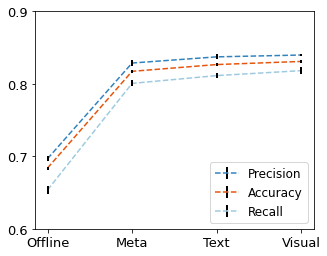

In [520]:
labels = ['Offline', 'Meta', 'Text', 'Visual']

x = np.arange(len(labels))

cmap = plt.cm.get_cmap('tab20c')

color1 = cmap(0)
color2 = cmap(2)
color3 = cmap(4)

fig, ax = plt.subplots(figsize=(5, 4))

ax.errorbar(x, points_prec, yerr=err_prec, fmt=',--', ecolor='black', color=color1, elinewidth=2, barsabove=True, label='Precision')
ax.errorbar(x, points_acc, yerr=err_acc, fmt=',--', ecolor='black', color=color3, elinewidth=2, barsabove=True, label='Accuracy')
ax.errorbar(x, points_rec, yerr=err_rec, fmt=',--', ecolor='black', color=color2, elinewidth=2, barsabove=True, label='Recall')




ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(labels, fontsize=13)

ax.set_yticks([0.6, 0.7, 0.8, 0.9])
ax.set_yticklabels([0.6, 0.7, 0.8, 0.9], fontsize=13)

#ax.set_xlabel('Complexity', fontsize=14)
#ax.set_ylabel('Average score', fontsize=14)

ax.legend(fontsize=12)

plt.show()